In [1]:
!pip install ISLP -q
!pip install great_tables
!pip install graphviz
!pip install dowhy
!pip install lightgbm
!pip install econml

ERROR: Could not find a version that satisfies the requirement nb21 (from versions: none)
ERROR: No matching distribution found for nb21


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

import pandas as pd
import numpy as np
from toolz import curry

@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])


In [3]:
df = pd.read_stata('./replication_sample.dta')
df_main = df[df['main_sample']==1].copy()
df_main = df_main.drop(columns=['allP_sample','main_sample','ind_sample',
                                'constant', 'logr_bar', 'r_hat', 'diffr_hat', 
                                'HHI_bar', 'logcpc', 'logvol', 'lognum', 'timetoswitch', 
                                'negative_HHIchange', 'shiftmerge', 'sapientmerge', 
                                'merklemerge', 'forsmanmerge', 'evermerged', 'sim'])

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_main, test_size=0.2, random_state=42)
train.head()

,year,newhclust,HHI_hat,num_words,num_char,long_tail,branded,numind,numberofresults,logr_hat,cluster,own_branded,other_branded
135123,2015,1460201,0.332331,3.572704,20.091198,0.454082,0.000,14,0.016987,8.179342,14602,0.000,0.000
210756,2016,2254903,0.101046,5.416667,30.416666,1.000000,0.000,22,0.030163,7.701984,22549,0.000,0.000
209273,2016,2249207,0.127522,4.000000,22.000000,1.000000,0.172,22,0.014100,9.813173,22492,0.172,0.828
112616,2015,1289005,0.500000,3.000000,16.000000,0.000000,0.000,12,0.053600,7.494289,12890,0.000,0.000
140999,2015,1487010,0.076364,3.118182,22.590910,0.118182,0.000,14,0.028082,12.683274,14870,0.000,0.000


# Simple Regression w/ Controls

## Parametric Final Model

<Axes: xlabel='HHI_hat', ylabel='logr_hat'>

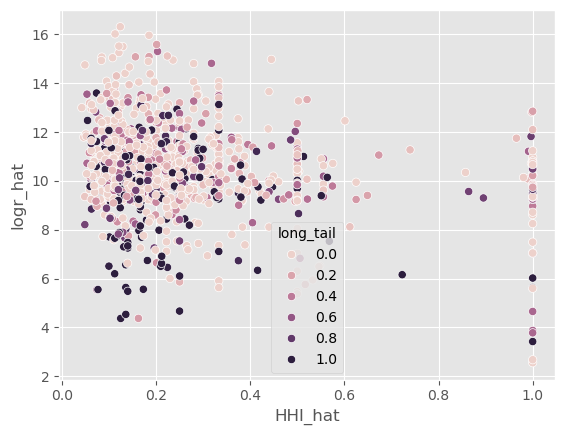

In [48]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="HHI_hat", y="logr_hat", hue="long_tail")

In [10]:
my = smf.ols("logr_hat~year+cluster+numberofresults+long_tail+branded", data=train).fit()
mt = smf.ols("HHI_hat~year+cluster+numberofresults+long_tail+branded", data=train).fit()

In [15]:
smf.ols("r_hat_res~HHI_res", 
        data=train.assign(r_hat_res=my.resid, # sales residuals
                          HHI_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.279e-13,0.009,9.22e-11,1.000,-0.018,0.018
HHI_res,-2.1357,0.040,-53.283,0.000,-2.214,-2.057


In [18]:
smf.ols("logr_hat~HHI_hat+year+cluster+numberofresults+long_tail+branded", data=train).fit().params["HHI_hat"]

-2.1356998345338427

In [102]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "logr_hat"
T = "HHI_hat"
X = ["year", "cluster", "numberofresults", "long_tail", "branded"]F

debias_m = LGBMRegressor(max_depth=3)

##treatment - treatment_hat
##out of box crossfitting function from sklearn
train_pred = train.assign(HHI_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 33584, number of used features: 5
[LightGBM] [Info] Start training from score 0.274001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

<Axes: xlabel='HHI_res', ylabel='logr_hat'>

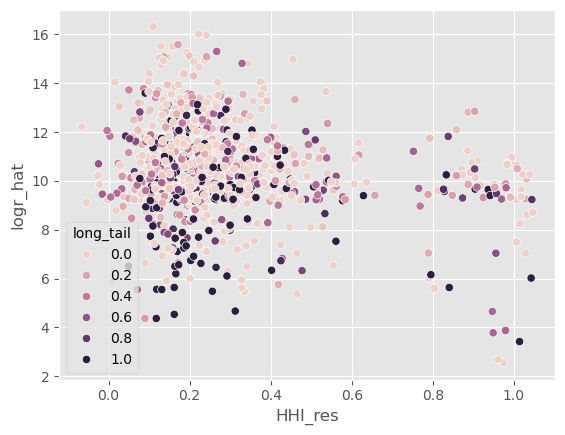

In [104]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="HHI_res", y="logr_hat", hue="long_tail")
#did not do much to fix issue?

In [106]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(r_hat_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 33584, number of used features: 5
[LightGBM] [Info] Start training from score 10.413940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

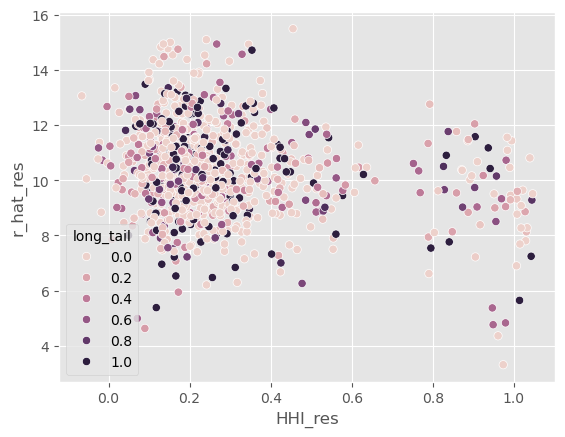

In [108]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="HHI_res", y="r_hat_res", hue="long_tail");

In [147]:
final_model = smf.ols(formula='r_hat_res ~ HHI_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.9924,0.013,829.335,0.000,10.966,11.018
HHI_res,-2.0812,0.038,-54.088,0.000,-2.157,-2.006


In [149]:
final_model_cate = smf.ols(formula='r_hat_res ~ HHI_res * (year+cluster+numberofresults+long_tail+branded)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(HHI_res=1))
                        - final_model_cate.predict(test.assign(HHI_res=0)))

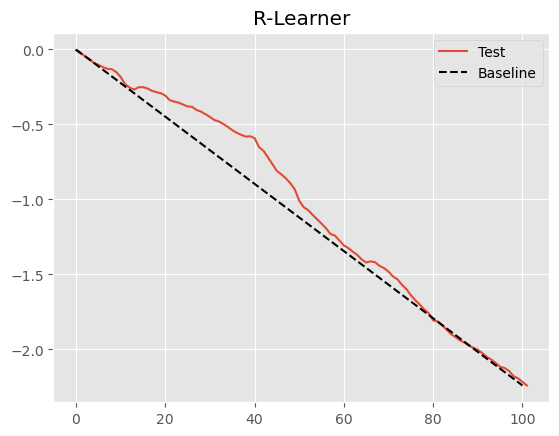

In [151]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

#sorting observations by treatment effect on X-axis. You want to see that the top percentage (those with the highest effect) are predicted very well

## Non-Parametric Final Model

In [198]:
model_final = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["HHI_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["r_hat_res"] / train_pred["HHI_res"])
 
# use a weighted regression ML model to predict the target with the weights.
# in order to minimize causal loss function
np_final = model_final.fit(X=train[X], y=y_star, sample_weight=w);

#Differences between Parametric DML and Non-Parametric DML
#1. Non-parametric final model instead of OLS
#2 Use causal loss objective function

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 41980, number of used features: 5
[LightGBM] [Info] Start training from score 23.340707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [162]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

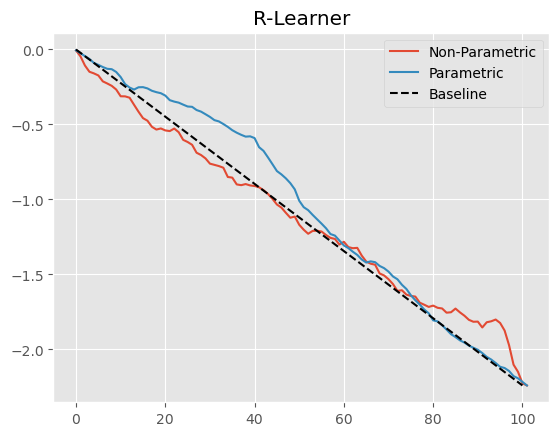

In [166]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

## Non-Scientific ML (Counterfactual Estimation)

In [184]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


In [186]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 33584, number of used features: 5
[LightGBM] [Info] Start training from score 10.413940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
# -1 on price saying that the predictions should not increase as price increases
#monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
#model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = LGBMRegressor(max_depth=3)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

In [ ]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")